In [13]:
# Notebook header <--- Always run this cell first!
import os, json
import ruamel.yaml as yaml
import numpy as np
import matplotlib, tikzplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
import tikzplotlib

from monty.json import MontyDecoder, MontyEncoder
from pymatgen.util.plotting import periodic_table_heatmap
from quotas.core import QuotasCalculator
from ipywidgets import interact, FloatSlider, SelectionSlider

data_dir = "../data"
figures_dir = "../../../figures/quotas"

# Load the dictionary of all the structures for which we have calculated the required properties
with open(os.path.join(data_dir, "yield.json"), "r") as file:
    yield_dict = json.loads(file.read(), cls=MontyDecoder)

# Also load the results without plasmon excitations
with open(os.path.join(data_dir, "yield_np.json"), "r") as file:
    yield_np_dict = json.loads(file.read(), cls=MontyDecoder)
    
# Define the effective ionization energies of the rare gas ions
ionization_energies = {
    "He": 24.56 - 2,
    "Ne": 21.56 - 1,
    "Ar": 15.76 - 0.5,
    "Kr": 12.00,
    "Xe": 10.13
}

color0 = (0.72156862745098,0.12156862745098,0.12156862745098)
color1 = (0.137254901960784,0.407843137254902,0.635294117647059)

## Periodic Table

In [6]:
def get_element_average(element, ion):
    
    average_yield = 0
    
    try:
        surfaces = [k for k in yield_dict[element].keys()]

        for surface in surfaces:
            if element in ["Si", "Ge"]:
                average_yield += yield_np_dict[element][surface][ion]["total_yield"]
            else:
                average_yield += yield_dict[element][surface][ion]["total_yield"]
        
        return average_yield / len(surfaces)
    
    except KeyError:
        
        if element == "Cr":
            phases = ['Cr_afm', 'Cr_nm']
        if element == "Fe":
            phases = ['Fe_alpha', 'Fe_gamma']
        elif element == "Hg":
            phases = ['Hg_alpha', 'Hg_beta']
        elif element == "Sn":
            phases = ['Sn_alpha', 'Sn_beta']
                
        for phase in phases:
            surfaces = [k for k in yield_dict[phase].keys()]

            for surface in surfaces:
                average_yield += yield_dict[phase][surface][ion]["total_yield"]
                
        return average_yield / len(surfaces) / len(phases)

In [7]:
l = [el for el in yield_dict.keys() if not len(el) > 2]
l.extend(["Cr", "Fe", "Hg", "Sn"])

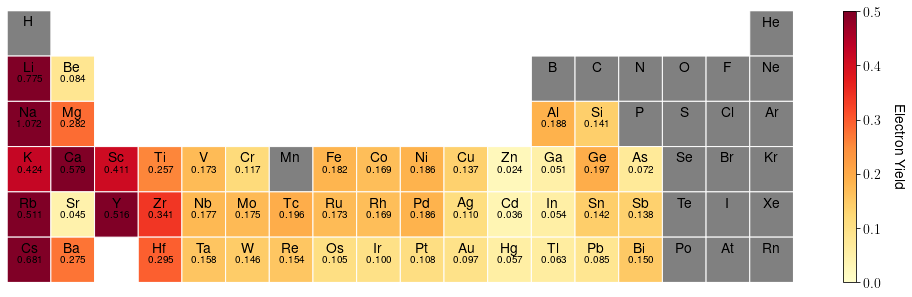

In [8]:
He_yield_dict = {e: get_element_average(e, "He") for e in l}

periodic_table_heatmap(He_yield_dict, max_row=6, cbar_label="Electron Yield", cmap_range=[0, 0.5], value_format="%.3f")
fig = plt.gcf()
fig.set_size_inches((14,4))
plt.savefig(format="png", dpi=300, fname=os.path.join(figures_dir, "He_yield_table.png"), bbox_inches="tight")

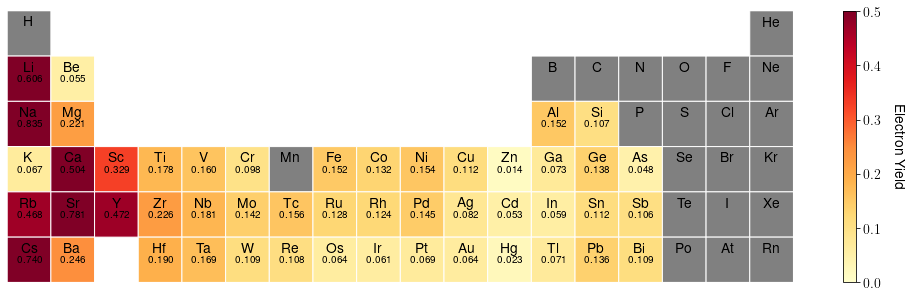

In [9]:
Ne_yield_dict = {e: get_element_average(e, "Ne") for e in l}
periodic_table_heatmap(Ne_yield_dict, max_row=6, cbar_label="Electron Yield", cmap_range=[0, 0.5], value_format="%.3f")
fig = plt.gcf()
fig.set_size_inches((14,4))
plt.savefig(format="png", dpi=300, fname=os.path.join(figures_dir, "Ne_yield_table.png"), bbox_inches="tight")

## Work function

In [14]:

total_yield_dict = {}

for ion in ionization_energies.keys():
    work_functions = []
    yields = []
    yields_np = []

    for element in yield_dict.keys():
        work_functions.extend([yield_dict[element][surface]['work_function']
                               for surface in yield_dict[element].keys()])
        yields.extend([surface[ion]["total_yield"] for surface in yield_dict[element].values()])
        yields_np.extend([surface[ion]["total_yield"] for surface in yield_np_dict[element].values()])
        
    total_yield_dict[ion] = {
        "ionization_energy": ionization_energies[ion],
        "work_functions": work_functions,
        "yields": yields,
        "yields_no_plasmons": yields_np
    }

def workfun_plot(ion, include_non_plasmon=False, highlight=None):
    
    highlight = "" or highlight
    
    plt.plot(total_yield_dict[ion]["work_functions"],
             total_yield_dict[ion]["yields"], "o", markersize=2, color=color0)
    plt.xlabel("Work function (eV)")
    plt.ylabel("Yield")
    
    if include_non_plasmon:
        plt.plot(total_yield_dict[ion]["work_functions"], 
                 total_yield_dict[ion]["yields_no_plasmons"], "o", markersize=2, color=color1)
    
    if highlight in yield_dict.keys():
        for surface, y in yield_dict[highlight].items():
            plt.plot(y["work_function"], y[ion]["total_yield"], "o", color="#F6FF68")
            if include_non_plasmon:
                plt.plot(yield_dict[highlight][surface]["work_function"],
                         yield_np_dict[highlight][surface][ion]["total_yield"],
                         "o", color="#61FFFF")
    return plt
    
def baragiola_plot(param1=0.78, param2=-2, logscale=False):
    
    for ion, ionization_energy in ionization_energies.items():
        x_values = param2 * np.array(total_yield_dict[ion]["work_functions"]) + param1 * ionization_energy
        plt.plot(x_values, total_yield_dict[ion]["yields"], "o")
        plt.xlabel(str(param1) + " E_i " + str(param2) + " Wf (eV)")
        plt.ylabel("Yield")
        if logscale:
            plt.xscale("log")
            plt.yscale("log")
    plt.legend(list(ionization_energies.keys()))

def data_plotter(plot):
    
    if plot == "workfun":
        
        highlight_list = list(yield_dict.keys())
        a = SelectionSlider(options=highlight_list)
#         b = Combobox(options=highlight_list, placeholder='Choose Element')
#         mylink = jslink((a, 'value'), (b, 'value'))
        
        interact(workfun_plot, ion=ionization_energies.keys(),
                 include_non_plasmon=False,
                 highlight=a)      
        
    elif plot == "baragiola":

        interact(baragiola_plot,
                 param1=FloatSlider(value=0.78, min=0, max=3),
                 param2=FloatSlider(value=-2.0, min=-5, max=0),
                 logscale=False)
        

In [11]:
interact(data_plotter, plot=["workfun", "baragiola"])

interactive(children=(Dropdown(description='plot', options=('workfun', 'baragiola'), value='workfun'), Output(…

<function __main__.data_plotter(plot)>

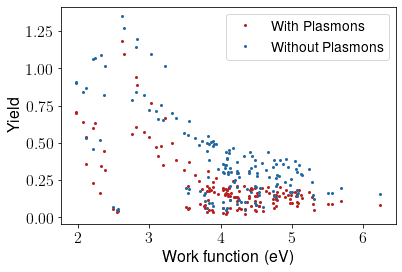

In [15]:
rc_font_dict = {"size": 16, "family": "sans-serif", 
                "sans-serif": ['Helvetica', 'Verdana', 'Tahoma', 'Lucida Grande']}
plt.rc("font", **rc_font_dict)
plt = workfun_plot("He", include_non_plasmon=True)
plt.legend(["With Plasmons", "Without Plasmons"], fontsize=14)
tikzplotlib.save(os.path.join(figures_dir, "versus_workfun.tex"),
                add_axis_environment=False)

## Occupied band width